# Exercises

In [1]:
# networks
import torch
from torch import nn
from torch.utils.data import DataLoader

# computer vision
from torchvision import datasets
from torchvision.transforms import ToTensor

# for model evaluation
from torchmetrics import Accuracy, ConfusionMatrix

# for model description
from torchsummary import summary

# for progress bar
from tqdm.auto import tqdm

# visualization
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu"

In [3]:
def train_epoch(model, dataloader, optim,
                loss_function, score_function, dev=device):
    model.to(dev)
    model.train()
    loss_epoch, score_epoch = 0, 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
        y_logits = model(X_batch)
        loss = loss_function(y_logits, y_batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

        y_labels = y_logits.argmax(dim=1)
        loss_epoch += loss
        score_epoch += score_function(y_labels, y_batch)

    loss_epoch /= len(dataloader)
    score_epoch /= len(dataloader)
    print(f'Train: loss = {loss_epoch.item():.5f}, score = {score_epoch:.3f}')
    return loss_epoch, score_epoch

In [4]:
def test_epoch(model, dataloader,
               loss_function, score_function, dev=device):
    model.to(dev)
    model.eval()
    with torch.inference_mode():
        loss_epoch, score_epoch = 0, 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
            y_logits = model(X_batch)
            y_labels = y_logits.argmax(dim=1)

            loss = loss_function(y_logits, y_batch)
            score = score_function(y_labels, y_batch)
            loss_epoch += loss
            score_epoch += score

        loss_epoch /= len(dataloader)
        score_epoch /= len(dataloader)
        print(f'Test: loss = {loss_epoch.item():.5f}, score = {score_epoch:.3f}')
        return loss_epoch, score_epoch

In [5]:
def make_predictions(model, data):
    model.eval()
    y_stack = []
    with torch.inference_mode():
        for image, label in data:
            y_logits = model(image.unsqueeze(dim=0))
            y_label = y_logits.argmax(dim=1)
            y_stack.append(y_label)
    return torch.cat(y_stack)

### 5. Load the torchvision.datasets.MNIST() train and test datasets.

In [6]:
train_data = datasets.MNIST(root='data/',
                            download=True,
                            train=True,
                            transform=ToTensor())
test_data = datasets.MNIST(root='data/',
                           download=True,
                           train=False,
                           transform=ToTensor())

In [7]:
print('Samples in train - {} and in test - {}'.format(len(train_data), len(test_data)))

class_names = test_data.classes
print(f'Classes: {class_names}')

sample, target = train_data[0]
print(f'Shape of image is {sample.shape}')

Samples in train - 60000 and in test - 10000
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Shape of image is torch.Size([1, 28, 28])


### 6. Visualize at least 5 different samples of the MNIST training dataset.

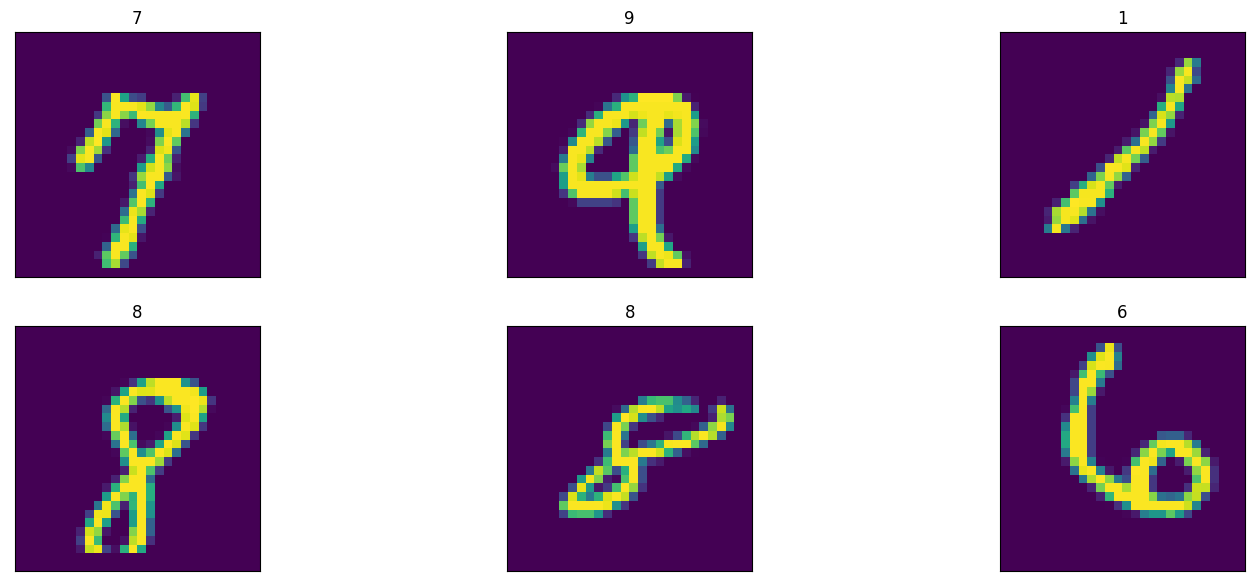

In [8]:
torch.manual_seed(42)

plt.figure(figsize=(18, 7))
for i in range(1, 7):
    rand_index = torch.randint(low=0, high=len(train_data)-1, size=[1]).item()
    sample, target = train_data[rand_index]
    sample = sample.squeeze()
    plt.subplot(2, 3, i)
    plt.imshow(sample)
    plt.title(target)
    plt.xticks([])
    plt.yticks([])

### 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [9]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

print('Batches: {} in train and {} in test'.format(len(train_dataloader), len(test_dataloader)))

Batches: 1875 in train and 313 in test


### 8. Create TinyVGG

In [10]:
class TinyVGG(nn.Module):
    def __init__(self, input_channels, output_classes, hidden_channels):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=4*4*hidden_channels,
                      out_features=output_classes)
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

In [11]:
torch.manual_seed(42)

tiny_model = TinyVGG(input_channels=1, output_classes=10, hidden_channels=10).to(device)
summary(tiny_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             910
              ReLU-4           [-1, 10, 24, 24]               0
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 10, 10, 10]             910
              ReLU-7           [-1, 10, 10, 10]               0
            Conv2d-8             [-1, 10, 8, 8]             910
              ReLU-9             [-1, 10, 8, 8]               0
        MaxPool2d-10             [-1, 10, 4, 4]               0
          Flatten-11                  [-1, 160]               0
           Linear-12                   [-1, 10]           1,610
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
-----------------------------------

### 9. Train the model you built in exercise 8

In [12]:
optimizer = torch.optim.SGD(params=tiny_model.parameters(),
                            lr=0.1, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(num_classes=10)

In [13]:
epochs = 3

# result_loss_train = []
# result_loss_test = []
# result_score_train = []
# result_score_test = []

for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch}/{epochs}')
    loss_train, score_train = train_epoch(model=tiny_model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_fn,
                                          optim=optimizer,
                                          score_function=accuracy)

    loss_test, score_test = test_epoch(model=tiny_model,
                                       dataloader=test_dataloader,
                                       loss_function=loss_fn,
                                       score_function=accuracy)

    # result_loss_train.append(loss_train)
    # result_loss_test.append(loss_test)
    # result_score_train.append(score_train)
    # result_score_test.append(score_test)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Train: loss = 0.36132, score = 0.879
Test: loss = 0.11733, score = 0.965
Epoch 2/3
Train: loss = 0.13768, score = 0.958
Test: loss = 0.14726, score = 0.950
Epoch 3/3
Train: loss = 0.12875, score = 0.961
Test: loss = 0.09490, score = 0.969


### 10. Make predictions using your trained model and visualize at least 5 of them comparing the predictions to the target label.

In [14]:
indexes_sample = torch.randint(low=0,
                               high=len(test_data),
                               size=[9])
test_samples = []
test_labels = []
for i in indexes_sample:
    image, label = test_data[i]
    test_samples.append(image)
    test_labels.append(label)
print('original labels:', test_labels)

original labels: [8, 7, 1, 4, 7, 6, 3, 4, 9]


In [15]:
tiny_model.eval()
y_stack = []
with torch.inference_mode():
    for sample in test_samples:
        y_logits = tiny_model(sample.unsqueeze(dim=0))
        y_label = y_logits.argmax(dim=1)
        y_stack.append(y_label)
predicted_labels = torch.cat(y_stack)
print('predicted labels:', predicted_labels)

predicted labels: tensor([8, 7, 1, 4, 7, 6, 3, 4, 9])


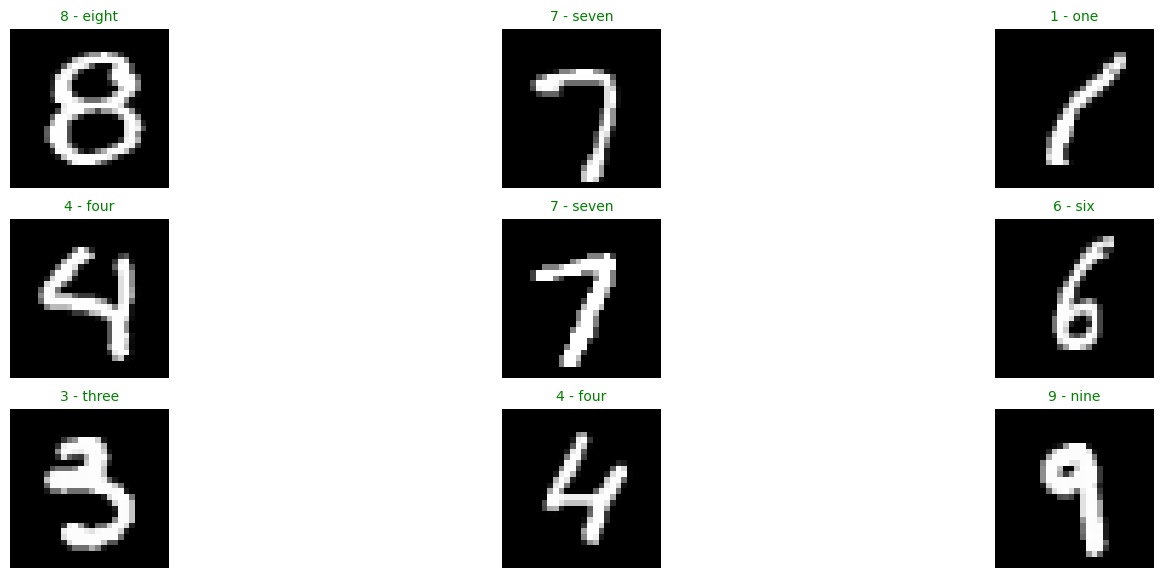

In [16]:
plt.figure(figsize=(18, 7))
ncols, nrows = 3, 3
for i, image in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    title_text = class_names[test_labels[i]]
    if predicted_labels[i] == test_labels[i]:
        plt.title(title_text, fontsize=10, c='green')
    else:
        plt.title(title_text, fontsize=10, c='red')
    plt.axis(False)

### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [17]:
predicted = make_predictions(model=tiny_model, data=test_data)

In [18]:
print('Accuracy (final prediction):', accuracy(predicted, test_data.targets))

Accuracy (final prediction): tensor(0.9692)


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

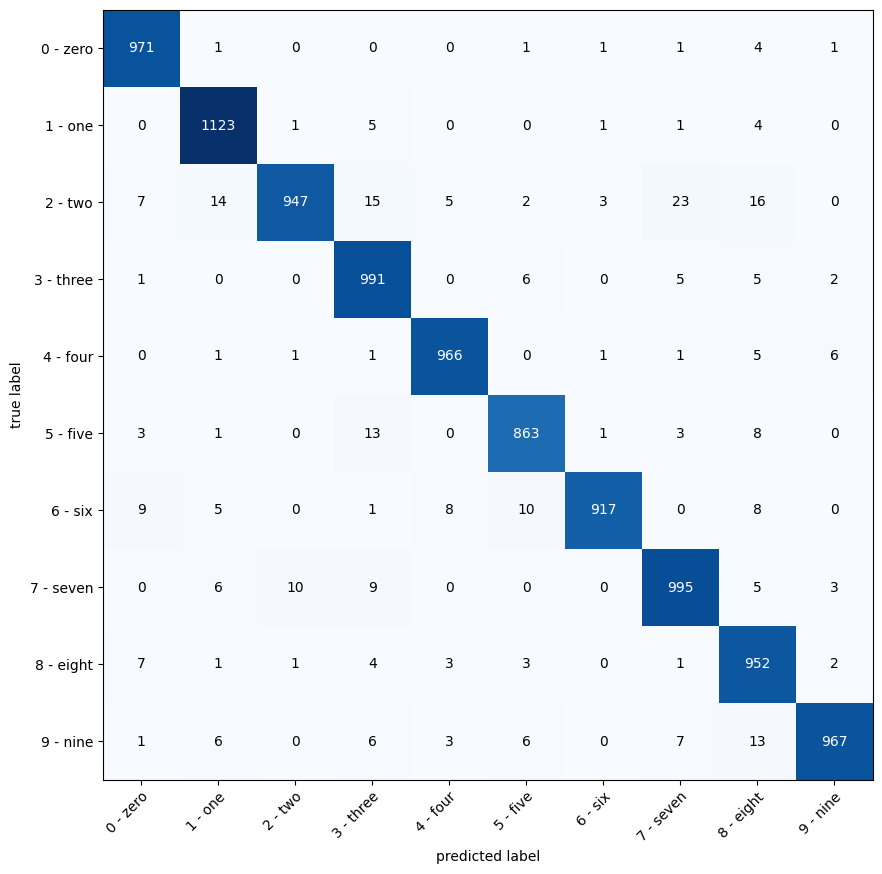

In [19]:
conf_matrix = ConfusionMatrix(num_classes=10)
cm_results = conf_matrix(preds=predicted,
                         target=test_data.targets)
plot_confusion_matrix(conf_mat=cm_results.numpy(),
                      class_names=class_names,
                      figsize=(10,10))

### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [20]:
random_tensor = torch.rand((1, 3, 64, 64))
print('shape of image:', random_tensor.shape)

print('shape after convolution layer with:')
for kernel in [3, 5, 7]:
    for s in [1, 2, 3]:
        for pad in [0, 1, 2, 3]:
            conv_layer = nn.Conv2d(in_channels=3,
                                   kernel_size=kernel,
                                   stride=s,
                                   padding=pad,
                                   out_channels=5)
            result = conv_layer(random_tensor)
            print('kernel = {} || stride = {} || padding = {} === > {}'.format(kernel, s, pad, result.shape))

shape of image: torch.Size([1, 3, 64, 64])
shape after convolution layer with:
kernel = 3 || stride = 1 || padding = 0 === > torch.Size([1, 5, 62, 62])
kernel = 3 || stride = 1 || padding = 1 === > torch.Size([1, 5, 64, 64])
kernel = 3 || stride = 1 || padding = 2 === > torch.Size([1, 5, 66, 66])
kernel = 3 || stride = 1 || padding = 3 === > torch.Size([1, 5, 68, 68])
kernel = 3 || stride = 2 || padding = 0 === > torch.Size([1, 5, 31, 31])
kernel = 3 || stride = 2 || padding = 1 === > torch.Size([1, 5, 32, 32])
kernel = 3 || stride = 2 || padding = 2 === > torch.Size([1, 5, 33, 33])
kernel = 3 || stride = 2 || padding = 3 === > torch.Size([1, 5, 34, 34])
kernel = 3 || stride = 3 || padding = 0 === > torch.Size([1, 5, 21, 21])
kernel = 3 || stride = 3 || padding = 1 === > torch.Size([1, 5, 22, 22])
kernel = 3 || stride = 3 || padding = 2 === > torch.Size([1, 5, 22, 22])
kernel = 3 || stride = 3 || padding = 3 === > torch.Size([1, 5, 23, 23])
kernel = 5 || stride = 1 || padding = 0 === >

### 13. Use a model similar to the trained model_2 from this notebook to make predictions on the test torchvision.datasets.FashionMNIST dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?


In [23]:
train_data = datasets.FashionMNIST(root='data/',
                                   train=True,
                                   transform=ToTensor())
test_data = datasets.FashionMNIST(root='data/',
                                  train=False,
                                  transform=ToTensor())
print(f'Number of samples in test - {len(test_data)} and in train - {len(train_data)} ')
sample, target = train_data[0]
print(f'Shape of sample: {sample.shape}')

Number of samples in test - 10000 and in train - 60000 
Shape of sample: torch.Size([1, 28, 28])


In [28]:
# classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [40]:
train_dataloader = DataLoader(dataset=train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_data,
                             shuffle=False,
                             batch_size=BATCH_SIZE)
print(f'Number of batches in train - {len(train_dataloader)} and in test - {len(test_dataloader)}')

Number of batches in train - 1875 and in test - 313


In [43]:
torch.manual_seed(42)

tiny_model2 = TinyVGG(input_channels=1, output_classes=10, hidden_channels=10).to(device)
summary(tiny_model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             910
              ReLU-4           [-1, 10, 24, 24]               0
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 10, 10, 10]             910
              ReLU-7           [-1, 10, 10, 10]               0
            Conv2d-8             [-1, 10, 8, 8]             910
              ReLU-9             [-1, 10, 8, 8]               0
        MaxPool2d-10             [-1, 10, 4, 4]               0
          Flatten-11                  [-1, 160]               0
           Linear-12                   [-1, 10]           1,610
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
-----------------------------------

In [44]:
optimizer = torch.optim.Adam(params=tiny_model2.parameters(),
                            lr=0.01)
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(num_classes=10)

In [45]:
epochs = 3

for epoch in range(1, epochs+1):
    print(f'Epoch {epoch}/{epochs}:')
    train_epoch(model=tiny_model2,
                dataloader=train_dataloader,
                loss_function=loss_fn,
                optim=optimizer,
                score_function=accuracy)
    test_epoch(model=tiny_model2,
               loss_function=loss_fn,
               score_function=accuracy,
               dataloader=test_dataloader)
    print()

Epoch 1/3:
Train: loss = 0.55222, score = 0.795
Test: loss = 0.48136, score = 0.825

Epoch 2/3:
Train: loss = 0.43895, score = 0.838
Test: loss = 0.46485, score = 0.829

Epoch 3/3:
Train: loss = 0.42495, score = 0.844
Test: loss = 0.42692, score = 0.842



In [63]:
predicted = make_predictions(model=tiny_model2, data=test_data)
unhappy = (predicted == test_data.targets)

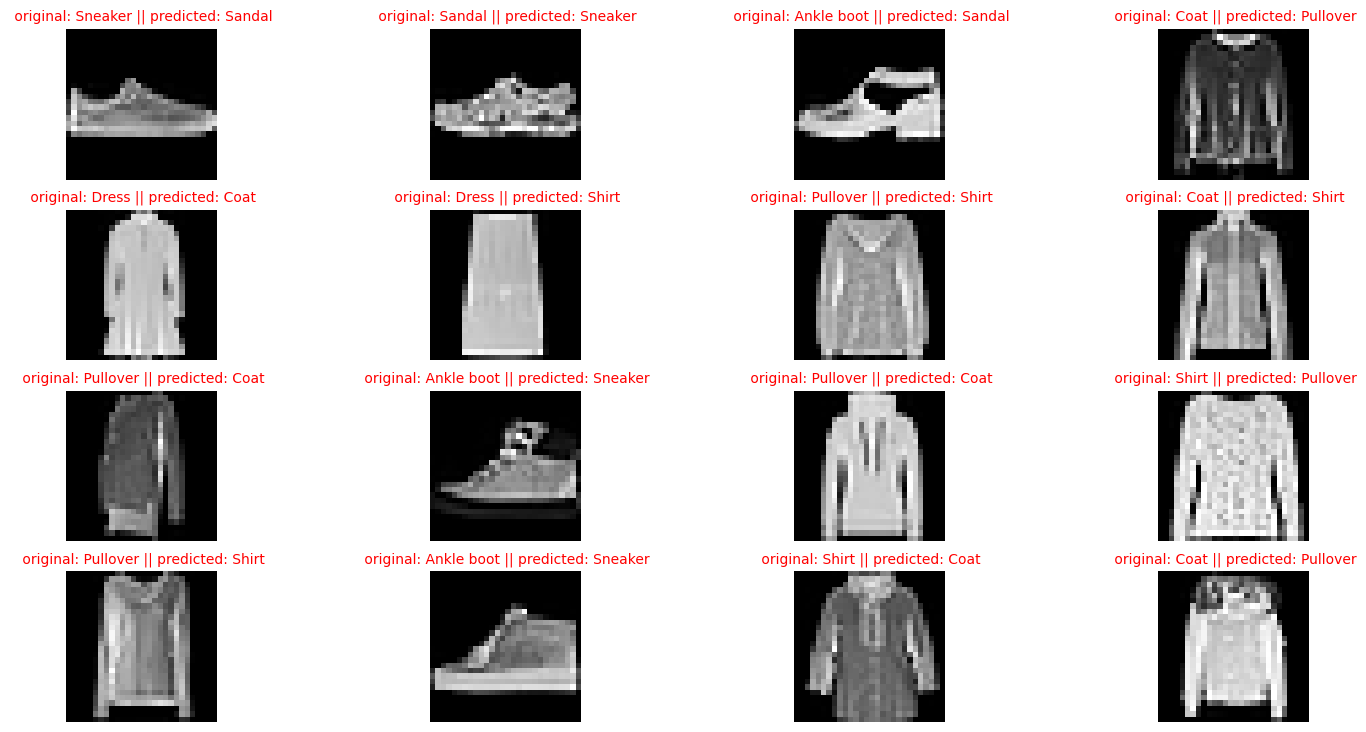

In [67]:
plt.figure(figsize = (18, 9))
ncols, nrows = 4, 4
index = 0
i = 0
while index < 16:
    while unhappy[i]:
        i += 1
    sample, target = test_data[i]
    plt.subplot(nrows, ncols, index+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    title_text = class_names[test_data.targets[i]]
    predicted_text = class_names[predicted[i]]
    plt.title(f' original: {title_text} || predicted: {predicted_text}', fontsize=10, c='red')
    plt.axis(False)
    index += 1
    i += 1